# Eye-Tracking Data Analysis of Users

In [136]:
import json
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from collections import defaultdict

In [137]:
def load_user_data(file_path):
    """Load JSON data from a file and convert to DataFrame"""
    with open(file_path, 'r') as f:
        # Check if the file contains a list of JSON objects or a single JSON object
        content = f.read()
        try:
            data = json.loads(content)
            if isinstance(data, list):
                df = pd.DataFrame(data)
            else:
                # If it's a single object, convert to list with one element
                df = pd.DataFrame([data])
        except json.JSONDecodeError:
            # If it's a JSONL (one JSON per line)
            data = [json.loads(line) for line in content.strip().split('\n')]
            df = pd.DataFrame(data)
    
    return df

In [138]:
def process_all_users(directory_path):
    """Process all JSON files in a directory, organizing by user and point cloud"""
    user_data = defaultdict(dict)
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)

            parts = filename.split('_')
            if len(parts) >= 3:
                user_id = parts[1]
                pc_name = parts[2].split('.')[0]  # Remove file extension
                df = load_user_data(file_path)
                user_data[user_id][pc_name] = df
    
    return user_data

In [139]:
def calculate_movement_metrics(df, fps=25):
    """Calculate movement metrics for a user"""
    metrics = {}
    
    # 1. Head position movement (using gaze origin as proxy for head position)
    origin_positions = df[['gazeOriginX', 'gazeOriginY', 'gazeOriginZ']].values
    head_displacements = np.zeros(len(origin_positions) - 1)
    
    for i in range(1, len(origin_positions)):
        head_displacements[i-1] = distance.euclidean(origin_positions[i], origin_positions[i-1])
    
    metrics['total_head_movement'] = np.sum(head_displacements)
    metrics['max_head_displacement'] = np.max(head_displacements) if len(head_displacements) > 0 else 0
    metrics['avg_head_velocity'] = np.mean(head_displacements) * fps if len(head_displacements) > 0 else 0
    
    # 2. Gaze direction changes
    gaze_directions = df[['gazeDirectionNormalisedX', 'gazeDirectionNormalisedY', 'gazeDirectionNormalisedZ']].values
    gaze_direction_changes = np.zeros(len(gaze_directions) - 1)
    
    for i in range(1, len(gaze_directions)):
        # Calculate angular change between consecutive gaze vectors
        dot_product = np.dot(gaze_directions[i], gaze_directions[i-1])
        # Ensure dot product is in valid range for arccos [-1, 1]
        dot_product = np.clip(dot_product, -1.0, 1.0)
        angle = np.arccos(dot_product)
        gaze_direction_changes[i-1] = np.degrees(angle)
    
    metrics['total_gaze_direction_change'] = np.sum(gaze_direction_changes)
    metrics['max_gaze_direction_change'] = np.max(gaze_direction_changes) if len(gaze_direction_changes) > 0 else 0
    metrics['avg_gaze_angular_velocity'] = np.mean(gaze_direction_changes) * fps if len(gaze_direction_changes) > 0 else 0
    
    return metrics

In [140]:
def categorize_user_movement(metrics, all_users_metrics):
    """Categorize users based on their movement metrics"""
    # Get distribution of head movement across all users
    head_movements = [m['total_head_movement'] for m in all_users_metrics.values()]
    head_q33 = np.percentile(head_movements, 33)
    head_q66 = np.percentile(head_movements, 66)
    
    # Get distribution of gaze changes across all users
    gaze_changes = [m['total_gaze_direction_change'] for m in all_users_metrics.values()]
    gaze_q33 = np.percentile(gaze_changes, 33)
    gaze_q66 = np.percentile(gaze_changes, 66)
    
    # Categorize based on both metrics
    if metrics['total_head_movement'] < head_q33 and metrics['total_gaze_direction_change'] < gaze_q33:
        return "low_movement"
    elif metrics['total_head_movement'] > head_q66 or metrics['total_gaze_direction_change'] > gaze_q66:
        return "high_movement"
    else:
        return "medium_movement"

In [141]:
def classify_eye_movements(df, fps=25, velocity_threshold_saccade=70.0, 
                          velocity_threshold_pursuit=30.0, 
                          fixation_duration_threshold=0.1, 
                          fixation_dispersion_threshold=0.05):
    """Classify eye movements into fixations, saccades, and smooth pursuits"""
    # Calculate gaze angular velocity
    gaze_directions = df[['gazeDirectionNormalisedX', 'gazeDirectionNormalisedY', 'gazeDirectionNormalisedZ']].values
    angular_velocities = np.zeros(len(gaze_directions))
    
    for i in range(1, len(gaze_directions)):
        dot_product = np.dot(gaze_directions[i], gaze_directions[i-1])
        dot_product = np.clip(dot_product, -1.0, 1.0)
        angle = np.arccos(dot_product)
        angular_velocities[i] = np.degrees(angle) * fps
    
    # Initial classification based on velocity thresholds
    classifications = []
    for vel in angular_velocities:
        if vel > velocity_threshold_saccade:
            classifications.append('saccade')
        elif vel > velocity_threshold_pursuit:
            classifications.append('smooth_pursuit')
        else:
            classifications.append('fixation')
    
    # Post-processing to enforce minimum fixation duration
    # A real fixation should last for at least a few frames
    min_fixation_frames = int(fixation_duration_threshold * fps)
    
    # First pass: merge adjacent fixations and handle isolated fixation points
    i = 0
    while i < len(classifications) - 1:
        if classifications[i] == 'fixation':
            # Count consecutive fixation frames
            fixation_start = i
            while (i + 1 < len(classifications) and 
                  classifications[i + 1] == 'fixation'):
                i += 1
            
            fixation_duration = i - fixation_start + 1
            
            # If fixation is too short, reclassify as smooth pursuit
            if fixation_duration < min_fixation_frames:
                for j in range(fixation_start, i + 1):
                    classifications[j] = 'smooth_pursuit'
        i += 1
    
    return classifications

In [142]:
def analyze_eye_movements(classifications, fps=25):
    """Analyze classified eye movements and return statistics"""
    stats = {
        'fixation_percentage': classifications.count('fixation') / len(classifications) * 100 if classifications else 0,
        'saccade_percentage': classifications.count('saccade') / len(classifications) * 100 if classifications else 0,
        'smooth_pursuit_percentage': classifications.count('smooth_pursuit') / len(classifications) * 100 if classifications else 0
    }
    
    # Calculate fixation count and mean fixation duration
    fixation_segments = []
    current_segment = []
    
    for i, cls in enumerate(classifications):
        if cls == 'fixation':
            current_segment.append(i)
        elif current_segment:
            fixation_segments.append(current_segment)
            current_segment = []
    
    if current_segment:
        fixation_segments.append(current_segment)
    
    stats['fixation_count'] = len(fixation_segments)
    if fixation_segments:
        avg_fixation_duration = np.mean([len(seg) for seg in fixation_segments]) / fps
        stats['avg_fixation_duration'] = avg_fixation_duration
    else:
        stats['avg_fixation_duration'] = 0
    
    return stats

In [143]:
def visualize_eye_movement_classification(df, classifications, output_path=None):
    """Visualize the eye movement classifications over time"""
    # Create a color map for classifications
    color_map = {'fixation': 'green', 'saccade': 'red', 'smooth_pursuit': 'blue'}
    colors = [color_map[cls] for cls in classifications]
    
    # Calculate gaze angular velocity for visualization
    gaze_directions = df[['gazeDirectionNormalisedX', 'gazeDirectionNormalisedY', 'gazeDirectionNormalisedZ']].values
    angular_velocities = np.zeros(len(gaze_directions))
    
    for i in range(1, len(gaze_directions)):
        dot_product = np.dot(gaze_directions[i], gaze_directions[i-1])
        dot_product = np.clip(dot_product, -1.0, 1.0)
        angle = np.arccos(dot_product)
        angular_velocities[i] = np.degrees(angle) * 30  # Assuming 30fps
    
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Angular velocity with classification colors
    plt.subplot(2, 1, 1)
    plt.title('Gaze Angular Velocity with Eye Movement Classification')
    plt.plot(angular_velocities, 'k-', alpha=0.5)
    plt.scatter(range(len(angular_velocities)), angular_velocities, c=colors, alpha=0.7)
    plt.ylabel('Angular Velocity (deg/s)')
    plt.grid(True, alpha=0.3)
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Fixation'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Saccade'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Smooth Pursuit')
    ]
    plt.legend(handles=legend_elements)
    
    # Plot 2: Classification over time
    plt.subplot(2, 1, 2)
    plt.title('Eye Movement Classification Timeline')
    
    # Create a categorical representation of classifications
    cat_values = [0 if cls == 'fixation' else (1 if cls == 'smooth_pursuit' else 2) for cls in classifications]
    plt.scatter(range(len(classifications)), cat_values, c=colors, alpha=0.7)
    plt.yticks([0, 1, 2], ['Fixation', 'Smooth Pursuit', 'Saccade'])
    plt.xlabel('Frame')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()
    
    plt.close()

In [144]:
def visualize_movement_categories(user_categories, all_user_metrics, output_path=None):
    """Visualize the movement categories distribution and key metrics"""
    # Count categories
    category_counts = {
        'low_movement': sum(1 for cat in user_categories.values() if cat == 'low_movement'),
        'medium_movement': sum(1 for cat in user_categories.values() if cat == 'medium_movement'),
        'high_movement': sum(1 for cat in user_categories.values() if cat == 'high_movement')
    }
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Category distribution
    plt.subplot(2, 2, 1)
    plt.title('Movement Category Distribution')
    categories = ['Low', 'Medium', 'High']
    counts = [category_counts['low_movement'], category_counts['medium_movement'], category_counts['high_movement']]
    plt.bar(categories, counts, color=['green', 'orange', 'red'])
    plt.ylabel('Number of Users')
    
    # Plot 2: Total head movement by category
    plt.subplot(2, 2, 2)
    plt.title('Total Head Movement by Category')
    
    category_head_movements = {
        'low_movement': [],
        'medium_movement': [],
        'high_movement': []
    }
    
    for user_id, category in user_categories.items():
        category_head_movements[category].append(all_user_metrics[user_id]['total_head_movement'])

    print(category_head_movements['low_movement'])
    print("dividing")

    # Divide per second
    category_head_movements['low_movement'] = [ x // 25.0 for x in category_head_movements['low_movement']]
    category_head_movements['medium_movement'] = [ x // 25.0 for x in category_head_movements['medium_movement']]
    category_head_movements['high_movement'] = [ x // 25.0 for x in category_head_movements['high_movement']]

    print(category_head_movements['low_movement'])


    plt.boxplot([category_head_movements['low_movement'] , 
                category_head_movements['medium_movement'] , 
                category_head_movements['high_movement'] ])
    plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'])
    plt.ylabel('Total Head Movement (per second)')
    
    # Plot 3: Total gaze direction change by category
    plt.subplot(2, 2, 3)
    plt.title('Total Gaze Direction Change by Category')
    
    category_gaze_changes = {
        'low_movement': [],
        'medium_movement': [],
        'high_movement': []
    }
    
    for user_id, category in user_categories.items():
        category_gaze_changes[category].append(all_user_metrics[user_id]['total_gaze_direction_change'])
    
    category_gaze_changes['low_movement'] = [ x // 1025.0 for x in category_gaze_changes['low_movement']]
    category_gaze_changes['medium_movement'] = [ x // 1025.0 for x in category_gaze_changes['medium_movement']]
    category_gaze_changes['high_movement'] = [ x // 1025.0  for x in category_gaze_changes['high_movement']]

    plt.boxplot([category_gaze_changes['low_movement'], 
                category_gaze_changes['medium_movement'], 
                category_gaze_changes['high_movement']])
    plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'])
    plt.ylabel('Total Gaze Direction Change (degrees, per second)')
    
    # Plot 4: Scatter plot of head movement vs gaze direction change
    plt.subplot(2, 2, 4)
    plt.title('Head Movement vs Gaze Direction Change')
    
    colors = {'low_movement': 'green', 'medium_movement': 'orange', 'high_movement': 'red'}
    
    for user_id, category in user_categories.items():
        plt.scatter(
            all_user_metrics[user_id]['total_head_movement'] / 10.250 , # divide by 25 for seconds, by 41 for users and multiply by 100 for meters to centimeter conversion
            all_user_metrics[user_id]['total_gaze_direction_change'] / 1025.0 ,
            color=colors[category],
            alpha=0.7
        )
    
    plt.xlabel('Total Head Movement')
    plt.ylabel('Total Gaze Direction Change (degrees, per second)')
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Low Movement'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medium Movement'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Movement')
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
        
    plt.show()
    
    plt.close()

In [145]:
DATA_DIR = "./Eye-Tracking-JSON"
OUTPUT_DIR = "./Eye-Tracking-Results"

In [146]:
# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [147]:
# Process all users data
print("Loading and processing user data...")
user_data = process_all_users(DATA_DIR)

user_data

Loading and processing user data...


defaultdict(dict,
            {'User51': {'PCBlueSpin':        pcName  pcFrameIndex  gazeOriginX  gazeOriginY  gazeOriginZ  \
              0    BlueSpin            -1     0.327187     0.062811     0.224411   
              1    BlueSpin             0     0.326872     0.062807     0.225204   
              2    BlueSpin             1     0.325585     0.062820     0.227732   
              3    BlueSpin             2     0.324719     0.062818     0.229337   
              4    BlueSpin             3     0.323922     0.062805     0.230875   
              ..        ...           ...          ...          ...          ...   
              495  BlueSpin           244    -0.849354     0.072797     1.867966   
              496  BlueSpin           245    -0.842486     0.072099     1.853862   
              497  BlueSpin           246    -0.832082     0.070695     1.831603   
              498  BlueSpin           247    -0.825221     0.069557     1.816189   
              499  BlueSpin       

In [148]:
# Calculate movement metrics for all users
print("Calculating movement metrics...")
all_user_metrics = {}

for user_id, pc_data in user_data.items():
    user_metrics = {}
    for pc_name, df in pc_data.items():
        user_metrics[pc_name] = calculate_movement_metrics(df)
    
    # Aggregate metrics across all point clouds for this user
    all_user_metrics[user_id] = {
        'total_head_movement': sum(m['total_head_movement'] for m in user_metrics.values()),
        'max_head_displacement': max(m['max_head_displacement'] for m in user_metrics.values()),
        'avg_head_velocity': np.mean([m['avg_head_velocity'] for m in user_metrics.values()]),
        'total_gaze_direction_change': sum(m['total_gaze_direction_change'] for m in user_metrics.values()),
        'max_gaze_direction_change': max(m['max_gaze_direction_change'] for m in user_metrics.values()),
        'avg_gaze_angular_velocity': np.mean([m['avg_gaze_angular_velocity'] for m in user_metrics.values()])
    }

all_user_metrics

Calculating movement metrics...


{'User51': {'total_head_movement': np.float64(42.3101804354406),
  'max_head_displacement': np.float64(0.44427708911551256),
  'avg_head_velocity': np.float64(0.5299371297024122),
  'total_gaze_direction_change': np.float64(4062.621365421014),
  'max_gaze_direction_change': np.float64(41.726138719441444),
  'avg_gaze_angular_velocity': np.float64(50.88453614004276)},
 'User52': {'total_head_movement': np.float64(46.114188672708025),
  'max_head_displacement': np.float64(0.3567219250831679),
  'avg_head_velocity': np.float64(0.5775825234557619),
  'total_gaze_direction_change': np.float64(3848.621193299611),
  'max_gaze_direction_change': np.float64(34.447076926312214),
  'avg_gaze_angular_velocity': np.float64(48.20417326277069)},
 'User53': {'total_head_movement': np.float64(47.77789574983686),
  'max_head_displacement': np.float64(0.592756766523752),
  'avg_head_velocity': np.float64(0.5984205379488584),
  'total_gaze_direction_change': np.float64(3313.273290098204),
  'max_gaze_dire

In [149]:
# Categorize users based on movement
print("Categorizing users by movement...")
user_categories = {}
for user_id, metrics in all_user_metrics.items():
    user_categories[user_id] = categorize_user_movement(metrics, all_user_metrics)

user_categories

Categorizing users by movement...


{'User51': 'medium_movement',
 'User52': 'medium_movement',
 'User53': 'medium_movement',
 'User54': 'high_movement',
 'User55': 'high_movement',
 'User56': 'low_movement',
 'User57': 'medium_movement',
 'User58': 'low_movement',
 'User59': 'medium_movement',
 'User60': 'medium_movement',
 'User61': 'medium_movement',
 'User62': 'high_movement',
 'User63': 'high_movement',
 'User64': 'low_movement',
 'User65': 'high_movement',
 'User67': 'high_movement',
 'User68': 'medium_movement',
 'User69': 'medium_movement',
 'User70': 'low_movement',
 'User71': 'high_movement',
 'User72': 'high_movement',
 'User73': 'medium_movement',
 'User74': 'high_movement',
 'User75': 'low_movement',
 'User76': 'medium_movement',
 'User77': 'high_movement',
 'User78': 'high_movement',
 'User79': 'high_movement',
 'User80': 'high_movement',
 'User81': 'low_movement',
 'User82': 'medium_movement',
 'User83': 'medium_movement',
 'User84': 'medium_movement',
 'User85': 'medium_movement',
 'User86': 'high_movemen

In [150]:
# Classify eye movements for all users
print("Classifying eye movements...")
user_eye_movement_stats = {}

for user_id, pc_data in user_data.items():
    user_stats = {}
    for pc_name, df in pc_data.items():
        classifications = classify_eye_movements(df)
        stats = analyze_eye_movements(classifications)
        user_stats[pc_name] = {
            'classifications': classifications,
            'stats': stats
        }
        
        # Visualize eye movement classification for this point cloud
        output_path = os.path.join(OUTPUT_DIR, f'{user_id}_{pc_name}_eye_movements.png')
        visualize_eye_movement_classification(df, classifications, output_path)
    
    user_eye_movement_stats[user_id] = user_stats

user_eye_movement_stats

Classifying eye movements...


{'User51': {'PCBlueSpin': {'classifications': ['fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'saccade',
    'smooth_pursuit',
    'saccade',
    'smooth_pursuit',
    'saccade',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'saccade',
    'saccade',
    'smooth_pursuit',
    'saccade',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'saccade',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'saccade',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'smooth_pursuit',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation',
    'fixation

[np.float64(23.53915514954507), np.float64(33.18242308152605), np.float64(28.486291137941443), np.float64(30.11909431077297), np.float64(23.35879044669199), np.float64(27.827533441286178), np.float64(27.538454780617204)]
dividing
[np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(1.0)]


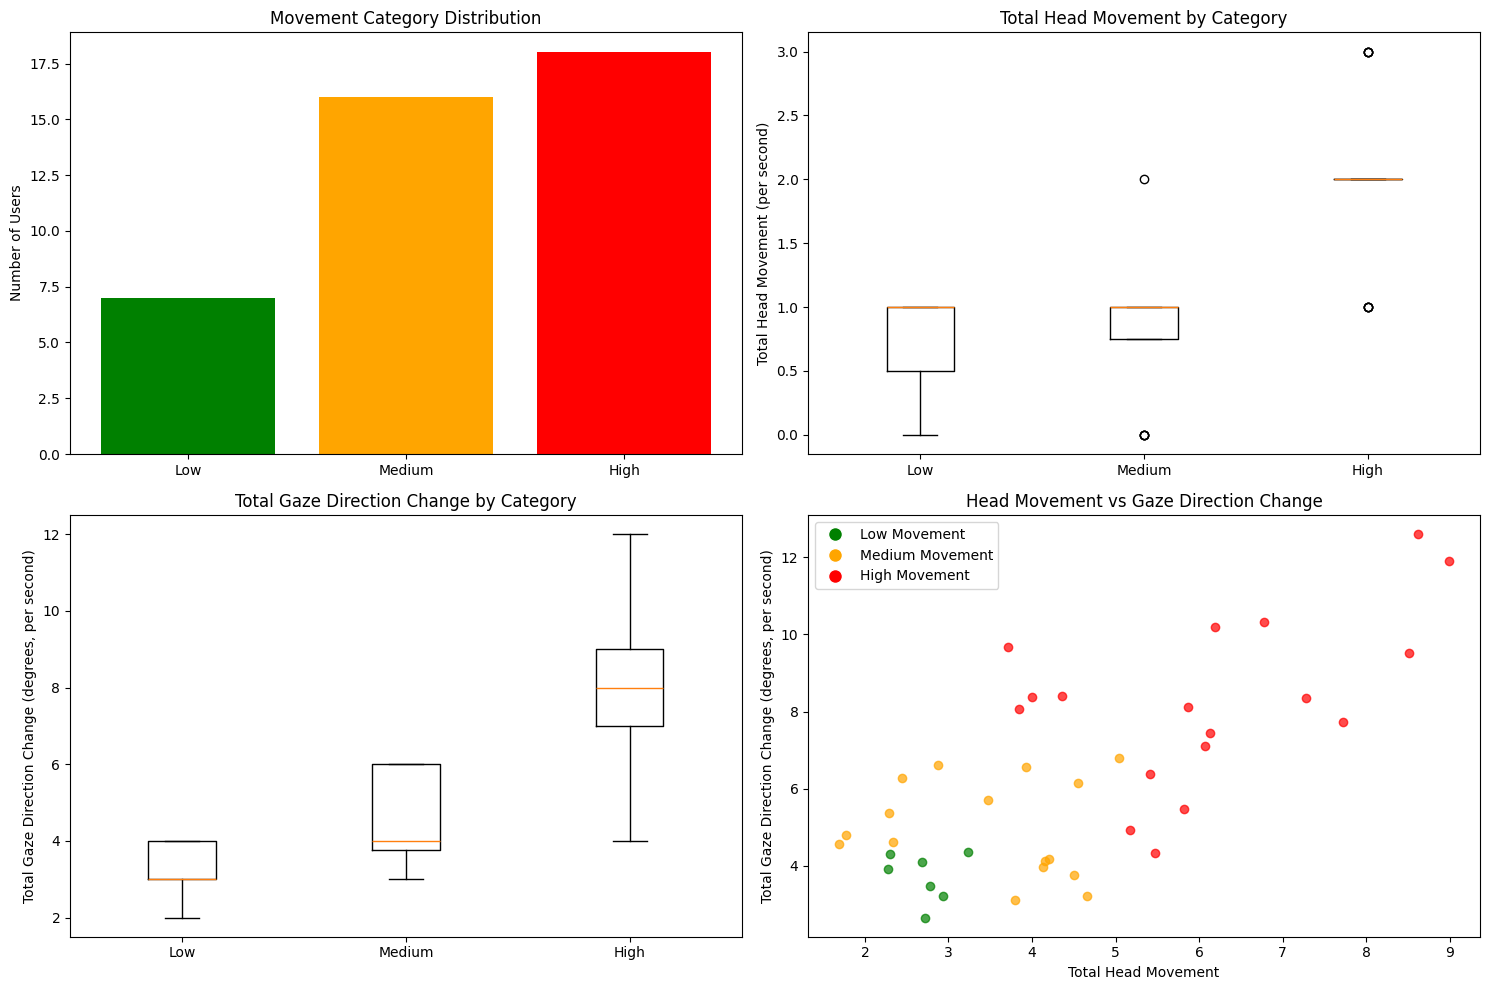

In [151]:
# Visualize movement categories
visualize_movement_categories(
    user_categories, 
    all_user_metrics,
    os.path.join(OUTPUT_DIR, 'movement_categories.png')
)

# CHECK THE UNITS OF TOTAL HEAD MOVEMENT

# gaze direction change per second or per frame

# check the literature from the eye tracking paper for IVT values

# check our previous work on eye tracking for the IVT threshold values

# check the error handling algorithm as well

In [152]:
# Generate summary report
print("Generating summary report...")
with open(os.path.join(OUTPUT_DIR, 'summary_report.txt'), 'w') as f:
    f.write("=== Eye-Tracking Analysis Summary Report ===\n\n")
    
    f.write("User Movement Categories:\n")
    for user_id, category in user_categories.items():
        f.write(f"User {user_id}: {category}\n")
    
    f.write("\nMovement Category Distribution:\n")
    f.write(f"Low Movement: {sum(1 for cat in user_categories.values() if cat == 'low_movement')} users\n")
    f.write(f"Medium Movement: {sum(1 for cat in user_categories.values() if cat == 'medium_movement')} users\n")
    f.write(f"High Movement: {sum(1 for cat in user_categories.values() if cat == 'high_movement')} users\n")
    
    f.write("\nEye Movement Statistics by User:\n")
    for user_id, pc_stats in user_eye_movement_stats.items():
        f.write(f"\nUser {user_id}:\n")
        
        # Calculate averages across all point clouds
        avg_fixation_pct = np.mean([s['stats']['fixation_percentage'] for s in pc_stats.values()])
        avg_saccade_pct = np.mean([s['stats']['saccade_percentage'] for s in pc_stats.values()])
        avg_pursuit_pct = np.mean([s['stats']['smooth_pursuit_percentage'] for s in pc_stats.values()])
        avg_fixation_count = np.mean([s['stats']['fixation_count'] for s in pc_stats.values()])
        avg_fixation_duration = np.mean([s['stats']['avg_fixation_duration'] for s in pc_stats.values()])
        
        f.write(f"  Movement Category: {user_categories[user_id]}\n")
        f.write(f"  Average Fixation Percentage: {avg_fixation_pct:.2f}%\n")
        f.write(f"  Average Saccade Percentage: {avg_saccade_pct:.2f}%\n")
        f.write(f"  Average Smooth Pursuit Percentage: {avg_pursuit_pct:.2f}%\n")
        f.write(f"  Average Fixation Count: {avg_fixation_count:.2f}\n")
        f.write(f"  Average Fixation Duration: {avg_fixation_duration:.4f} seconds\n")

Generating summary report...


In [153]:
print(f"Analysis complete! Results saved to {OUTPUT_DIR}")

print('user_categories')
print(user_categories)

print('all_user_metrics')
print(all_user_metrics)

print('user_eye_movement_stats')
print(user_eye_movement_stats)

Analysis complete! Results saved to ./Eye-Tracking-Results
user_categories
{'User51': 'medium_movement', 'User52': 'medium_movement', 'User53': 'medium_movement', 'User54': 'high_movement', 'User55': 'high_movement', 'User56': 'low_movement', 'User57': 'medium_movement', 'User58': 'low_movement', 'User59': 'medium_movement', 'User60': 'medium_movement', 'User61': 'medium_movement', 'User62': 'high_movement', 'User63': 'high_movement', 'User64': 'low_movement', 'User65': 'high_movement', 'User67': 'high_movement', 'User68': 'medium_movement', 'User69': 'medium_movement', 'User70': 'low_movement', 'User71': 'high_movement', 'User72': 'high_movement', 'User73': 'medium_movement', 'User74': 'high_movement', 'User75': 'low_movement', 'User76': 'medium_movement', 'User77': 'high_movement', 'User78': 'high_movement', 'User79': 'high_movement', 'User80': 'high_movement', 'User81': 'low_movement', 'User82': 'medium_movement', 'User83': 'medium_movement', 'User84': 'medium_movement', 'User85': '